In [24]:
%matplotlib inline

In [44]:
# 1. Import Libraries

import torch
import torch.nn as nn                   #sublibrary inside pytorch that focus on neural network
import torch.nn.functional as F         #contians functions for activation like ReLU,sigmoid
from torchvision import transforms       #library build on top of pytorch useful for orking with images, transform to change/prepare image before giving them to a neutral network eg resize an image,convert to grayscale
from PIL import Image        #PIL python imaging library helps to open,display and edit images
import matplotlib.pyplot as plt      #library for drawing charts and images


In [47]:
# 2. Define ResBlock

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)    # normalizes the value (keeps them stable, not too big or too small).
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x     #copy of input
        out = F.relu(self.bn1(self.conv1(x)))    # ReLU function that keeps positive balues and sets negatives to 0.
        out = self.bn2(self.conv2(out))      # we send through secound convolution and batchnorm
        out += identity        # adds original imput back to processed output.
        return F.relu(out)        #apply ReLU again final output block ,,, learns new features but never lose the original input.


In [49]:

# 3. Define Encoder

'''Encoder it compresses input images into smaller feature representations
(like summarizing an image into useful features).'''

class Encoder(nn.Module):
    def __init__(self, in_channels=3, D=256):      #depth 256 common size in deep nets
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, D, kernel_size=3, stride=1, padding=1)     # first layer conv: turns raw image (3 channels) into 256-channel feature map
        self.res256 = nn.Sequential(*[ResBlock(256) for _ in range(3)])       #sequence of 3 ResBlock each works with 256 channels, this extracts deep features while keeping information intact (So instead of just having Red/Green/Blue info, the network creates 256 new “views” of the image that help it understand complex patterns).
        self.down256to128 = nn.Conv2d(256, 128, kernel_size=1)            #1×1 convolution that reduces the number of channels from 256 → 128.
        self.res128 = nn.Sequential(*[ResBlock(128) for _ in range(2)])         #Helps refine features after compression.
        self.down128to64 = nn.Conv2d(128, 64, kernel_size=1)         #1×1 convolution reducing depth from 128 → 64.Even more compression.
        self.res64 = ResBlock(64)           #residual block working with 64 channels.keeps important features while being much smaller than before.
        self.conv_out = nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=3)     #A 7×7 convolution as the final step.

    def forward(self, x):   #Defines how data flows through the encoder.
        outputs = {}        #Creates a dictionary to store intermediate results at different stages.

        outputs['Input'] = x.clone()     #Saves the original input..clone() makes a copy (so we don’t overwrite it later).
        x = self.conv_in(x)
        outputs['Conv3x3 (256)'] = x.clone()

        x = self.res256(x)
        outputs['ResBlock x3 (256)'] = x.clone()

        x = self.down256to128(x)
        x = self.res128(x)
        outputs['ResBlock x2 (128)'] = x.clone()

        x = self.down128to64(x)
        x = self.res64(x)
        outputs['ResBlock x1 (64)'] = x.clone()

        x = self.conv_out(x)
        outputs['Conv7x7 (64)'] = x.clone()

        return outputs

In [27]:
from google.colab import files
uploaded = files.upload()

Saving 2 number.jpg to 2 number (2).jpg


In [40]:
# 4. Load and Preprocess Image

img = Image.open("2 number.jpg").convert("RGB")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),     #Turn the resized picture into numbers PyTorch can understand.0–255 → 0.0–1.0
])

inp = transform(img).unsqueeze(0)     # Shape: [1, 3, 64, 64] ,[Batch Size, Channels, Height, Width],we only have 1 image, batch size = 1.
print("Input Image Shape:", inp.shape)       #Prints the shape of the tensor.


Input Image Shape: torch.Size([1, 3, 64, 64])


In [41]:
# 5. Run Model

model = Encoder()
feature_maps = model(inp)    #runs the forward() function,how the image was processed at different stages.

In [45]:
def show_image(img, title="Input Image"):
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')    #Makes the plot look clean, like a proper image instead of a graph.
    plt.show()


#Function to visualize feature maps
def show_mean_feature_map(tensor, title="Mean Feature Map"):
    fmap = tensor.detach().squeeze(0).mean(dim=0).cpu()

    '''tensor → feature map, shape like [1, C, H, W]
    detach() → removes it from PyTorch’s computation graph (we don’t want gradients when just visualizing).
    squeeze(0) → removes the batch dimension.
      From [1, C, H, W] → [C, H, W].
    mean(dim=0) → takes the mean across channels.
      From [C, H, W] → [H, W].
      instead of 64 or 128 channels, combine  into one average 2D image.
    .cpu() → moves it to CPU memory (important if tensor is on GPU).
    '''
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)   #Normalizes the values of fmap between 0 and 1.

    plt.figure(figsize=(5, 5))
    plt.imshow(fmap, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


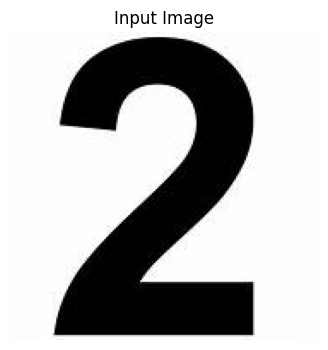

Input → Shape: torch.Size([1, 3, 64, 64])


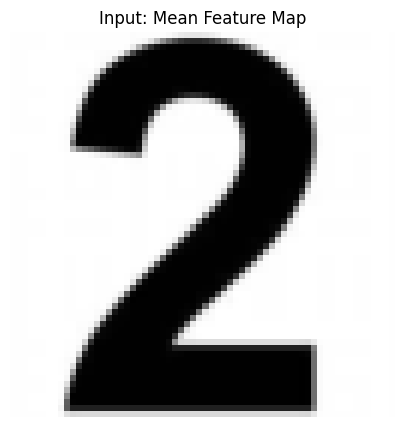

Conv3x3 (256) → Shape: torch.Size([1, 256, 64, 64])


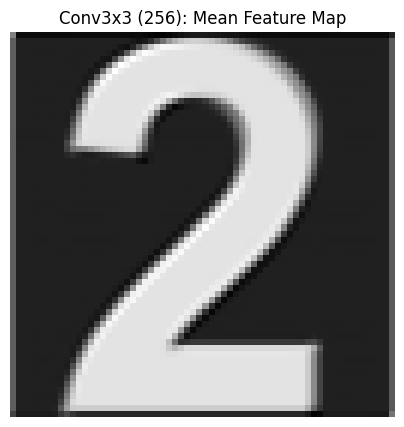

ResBlock x3 (256) → Shape: torch.Size([1, 256, 64, 64])


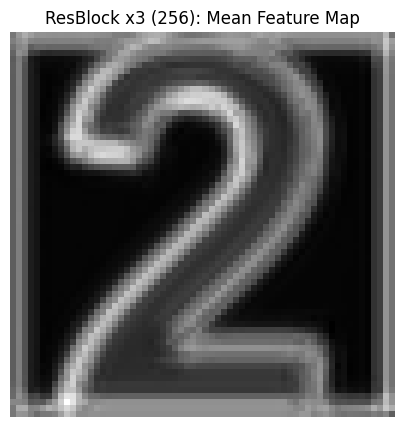

ResBlock x2 (128) → Shape: torch.Size([1, 128, 64, 64])


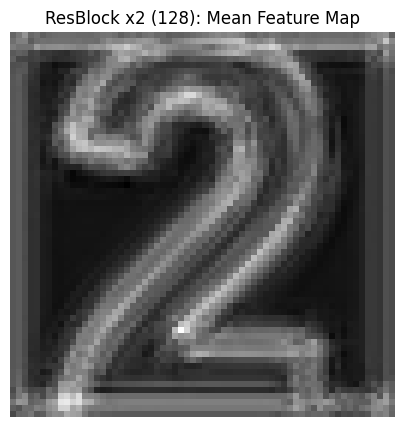

ResBlock x1 (64) → Shape: torch.Size([1, 64, 64, 64])


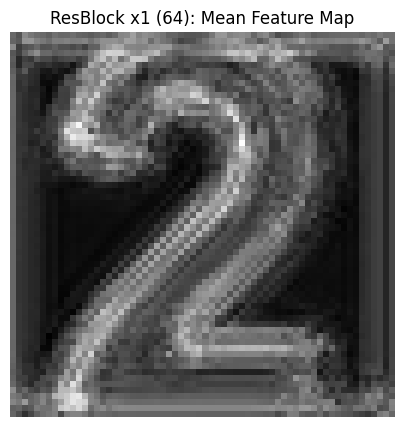

Conv7x7 (64) → Shape: torch.Size([1, 64, 64, 64])


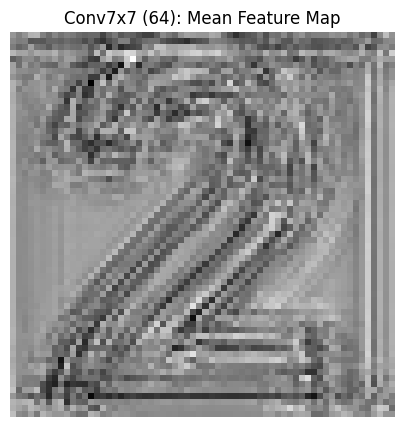

In [46]:
# Show input image
show_image(img, title="Input Image")

# Show Mean Feature Map of Each Layer
for layer_name, fmap in feature_maps.items():
    print(f"{layer_name} → Shape: {fmap.shape}")
    show_mean_feature_map(fmap, title=f"{layer_name}: Mean Feature Map")
